# Covid 19 Model Based on chest X-Ray Imgs

Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , ConcatDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
from sklearn.model_selection import KFold

import seaborn as sn  # for heatmaps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import csv
import cv2

Define Transformers and data sets and loaders.

In [2]:
torch.manual_seed(1234)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean,std)])
                             

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)])

train_data = datasets.ImageFolder('D:/Data/COVID-19-master/train', transform=train_transform)
valid_data = datasets.ImageFolder('D:/Data/COVID-19-master/valid', transform=test_transform)
dataset=ConcatDataset([train_data,valid_data])

train_loader = DataLoader(train_data, batch_size=32, shuffle=False)  ## Just for visualization purposes


test_data = datasets.ImageFolder('D:/Data/COVID-19-master/test', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print(class_names)
print(f'Training and Validation images available: {len(dataset)}')
print(f'Testing images available:  {len(test_data)}')

['Covid', 'Normal']
Training and Validation images available: 254
Testing images available:  30


# Initialize Use Cuda variable

In [3]:
use_cuda = torch.cuda.is_available()
use_cuda

False

(torch.Size([3, 224, 224]), torch.Size([32]))

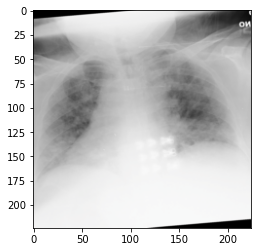

In [4]:
def imshow(image, ax=None):
    image = image.numpy().transpose((1, 2, 0))
    image = image * std + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image) if ax else plt.imshow(image)
    
img, _ = next(iter(train_loader))
imshow(img[0])
img[0].shape,_.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: [0 0 0 0 0 0 0 0 0 0]
Class: Covid Covid Covid Covid Covid Covid Covid Covid Covid Covid


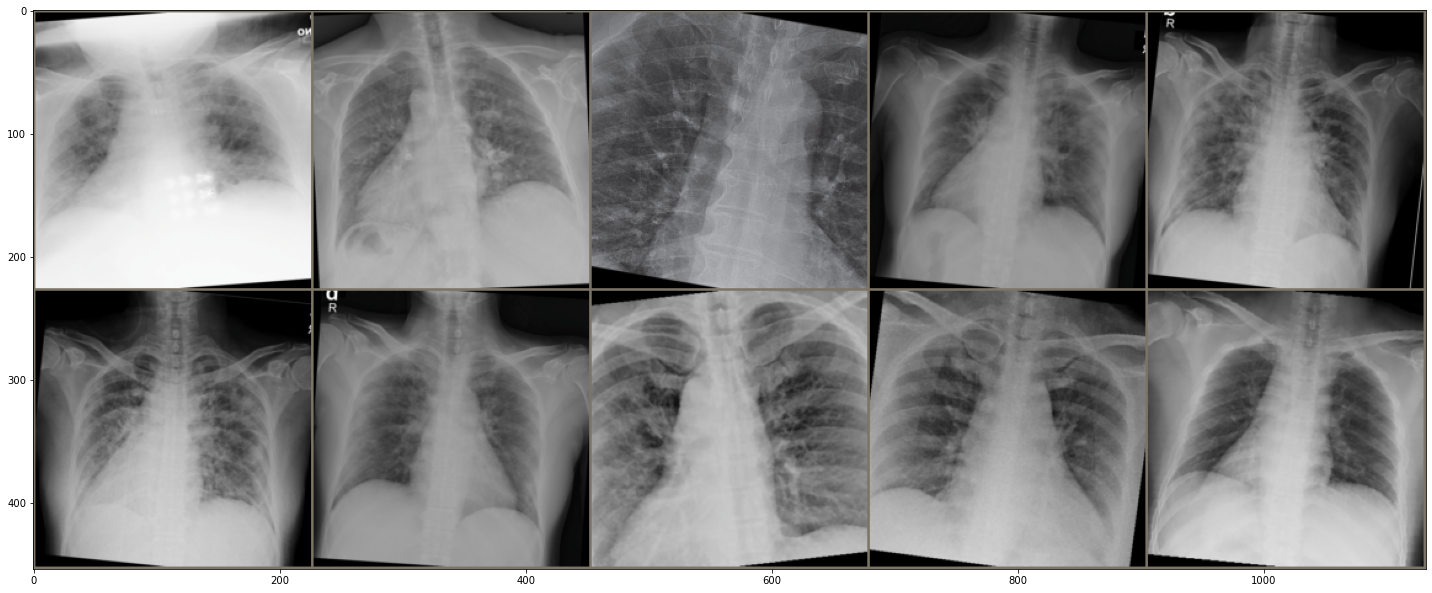

In [5]:
# Grab the first 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels[:10].numpy())
print('Class:', *np.array([class_names[i] for i in labels[:10]]))

im = make_grid(images[:10], nrow=5)  # the default nrow is 8

# Inverse normalize the images

im = im.numpy().transpose((1, 2, 0))
im = im * std + mean
plt.figure(figsize=(20,10))

# Print the images
plt.imshow(im)
plt.tight_layout()

# Define Train and Test Functions

In [6]:
def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    losses=np.zeros((n_epochs,2))
    
    for epoch in range(n_epochs):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for data, target in train_loader:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda().unsqueeze(1).float()
            
            out = model(data)
            loss = criterion(out, target.unsqueeze(1).float())  #to make them the same dimension.
            train_loss += loss.item()
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        ######################
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for data, target in valid_loader:
            with torch.no_grad():
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda().unsqueeze(1).float()

                    
                val_out = model(data)
                loss = criterion(val_out, target.unsqueeze(1).float())
                valid_loss += loss.item()
                
        
        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        losses[epoch]=(train_loss,valid_loss)
        
        
        # print training/validation statistics
        print(
            f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ... Model saved ...')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)

    return model, losses

In [7]:
def test(test_loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    y_true = np.array([])
    y_pred = np.array([])

    # set the module to evaluation mode
    model.eval()

    for data, target in test_loader:
        # move to GPU
        with torch.no_grad():
            if use_cuda:
                data, target = data.cuda(), target.cuda().unsqueeze(1).float()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target.unsqueeze(1).float())
            # update average test loss
            test_loss += loss.item()

            output = torch.sigmoid(output)
            y_true = np.append(y_true, target.cpu().numpy())
            y_pred = np.append(y_pred, output.cpu().numpy())

            
    test_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.6f}\n')

    return test_loss, y_true, y_pred

# Define The model

we will use a pre-trained model (googlenet model).

In [8]:
model = models.googlenet(pretrained=True)
#model
torch.manual_seed(1234)
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 128, bias=False),
                         nn.BatchNorm1d(128),
                         nn.ReLU(),
                         nn.Dropout(0.25),
                         nn.Linear(128, 1))

lr = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr )

we need to reset the weights of the model so that each cross-validation fold starts from some random initial state and not learning from the previous folds. You could call reset_parameters() on all child modules.

In [9]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Train The Model

In [28]:
import time
start_time = time.time()

kfold = KFold(n_splits=8, shuffle=False)
for fold,(train_idx,test_idx) in enumerate(kfold.split(dataset)):
    
    print('------------fold no---------{}----------------------'.format(fold))
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
    
    train_loader = DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    valid_loader = DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)
 
    model.apply(reset_weights)
 
    #for epoch in range(1, epochs + 1):
    #train(fold, model, device, trainloader, optimizer, epoch)
    if use_cuda:
        model = model.cuda()

    epochs =2
    model, losses = train(epochs, train_loader , valid_loader , model, optimizer, criterion, use_cuda, 'model7.pt')

    

model.load_state_dict(torch.load('model7.pt'))    
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

------------fold no---------0----------------------
Epoch: 1 	Training Loss: 0.716489 	Validation Loss: 0.000000
Validation loss decreased ... Model saved ...
Epoch: 2 	Training Loss: 0.648761 	Validation Loss: 0.007501
------------fold no---------1----------------------
Epoch: 1 	Training Loss: 0.665834 	Validation Loss: 0.088128
Validation loss decreased ... Model saved ...
Epoch: 2 	Training Loss: 0.637344 	Validation Loss: 0.296524
------------fold no---------2----------------------
Epoch: 1 	Training Loss: 0.652792 	Validation Loss: 0.147065
Validation loss decreased ... Model saved ...
Epoch: 2 	Training Loss: 0.655483 	Validation Loss: 6.965311
------------fold no---------3----------------------
Epoch: 1 	Training Loss: 0.678215 	Validation Loss: 37.899384
Validation loss decreased ... Model saved ...
Epoch: 2 	Training Loss: 0.609533 	Validation Loss: 28.120926
Validation loss decreased ... Model saved ...
------------fold no---------4----------------------
Epoch: 1 	Training L

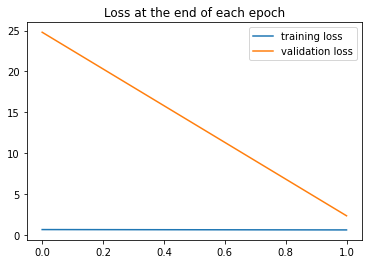

In [30]:
plt.plot(losses[:,0], label='training loss')
plt.plot(losses[:,1], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [31]:
model.load_state_dict(torch.load('model7.pt'))
test_loss, y_true, y_pred = test(test_loader, model, criterion, use_cuda)

Test Loss: 3.217742



In [32]:
y_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [33]:
# Test loss in small.
y_pred  # we need to turn the probabilities into binary values (0,1)

array([2.55134830e-04, 9.85892722e-04, 4.79406178e-01, 3.31948668e-01,
       2.77794345e-04, 1.37290403e-01, 7.41738904e-06, 3.05215508e-01,
       3.68026942e-01, 4.44731768e-06, 3.23450990e-08, 7.45546296e-02,
       4.89658952e-01, 2.69890100e-01, 1.34125528e-07, 2.26036403e-02,
       1.26427710e-01, 1.77701920e-01, 5.05769178e-02, 9.14505590e-03,
       2.38594366e-03, 1.98504515e-02, 8.98430403e-03, 5.39862327e-02,
       9.34971141e-08, 2.66079791e-04, 1.30969420e-01, 2.68280553e-03,
       4.31463646e-04, 1.29227729e-09])

In [34]:
#### cHANGE 2 PREDICTIONS JUST TO UNDERSTAND SOMETHINGS ####
##### WRONG STEP ######

y_pred=np.array([1, 4.45123151e-04, 2.44888593e-03, 7.36289250e-04,
       4.03730897e-04, 1.23097954e-04, 1.83839249e-04, 7.74210377e-04,
       5.16523840e-04, 2.36997206e-04, 4.55235597e-04, 1.18583441e-03,
       1.18710578e-03, 5.13183069e-04, 9.41234350e-04, 9.99984741e-01,
       9.99993324e-01, 9.99999881e-01, 1.00000000e+00, 9.99397874e-01,
       1.00000000e+00, 1.00000000e+00, 9.99998569e-01, 9.99998569e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99945283e-01,
       0, 0])

In [35]:
np.round(y_pred)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])

In [36]:
y_pred = torch.tensor(y_pred)
y_pred = torch.sigmoid(y_pred)
y_pred

tensor([0.7311, 0.5001, 0.5006, 0.5002, 0.5001, 0.5000, 0.5000, 0.5002, 0.5001,
        0.5001, 0.5001, 0.5003, 0.5003, 0.5001, 0.5002, 0.7311, 0.7311, 0.7311,
        0.7311, 0.7309, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311,
        0.7310, 0.5000, 0.5000], dtype=torch.float64)

In [37]:
for i in range(len(y_pred)):
    if y_pred[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

In [38]:
y_pred

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)

Calculate and plot some metrics modules

In [39]:
from sklearn.metrics import  accuracy_score, precision_score,roc_auc_score, f1_score,recall_score, precision_recall_curve, classification_report, roc_curve, auc, confusion_matrix ,  average_precision_score,  plot_precision_recall_curve

[[ 0 15]
 [ 0 15]]


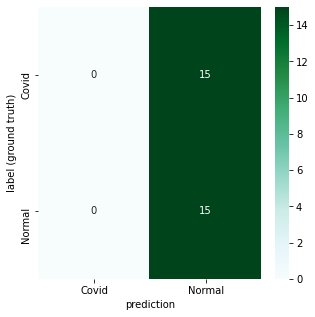

In [40]:
arr = confusion_matrix(y_true,y_pred)
print(arr)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [41]:
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred)
print('Precision: %f' % precision)

Precision: 0.500000


In [42]:
 # recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred)
print('Recall: %f' % recall)

Recall: 1.000000


In [43]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred)
print('F1 score: %f' % f1)        

F1 score: 0.666667


In [44]:
def cal_F1Score(precision, recall):
    f1_score = 2*(precision * recall)/(precision + recall)
    return f1_score
cal_F1Score(precision,recall)

#SAME NUMBER

0.6666666666666666

In [45]:
    # ROC AUC
auc = roc_auc_score(y_true, y_pred)
print('ROC AUC: %f' % auc)

ROC AUC: 0.500000


No handles with labels found to put in legend.


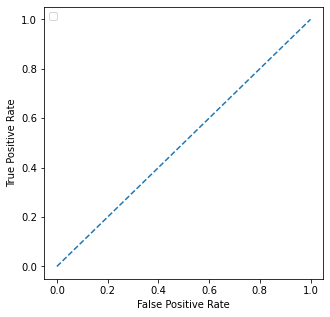

In [46]:
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive

# calculate roc curves
fpr, tpr, _ = roc_curve(y_true, y_pred)
        
    # plot the roc curve for the model
plt.figure(figsize = (5,5))
plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
plt_False_Positive_vs_True_Positive.legend()
    # show the plot
plt_False_Positive_vs_True_Positive.show()

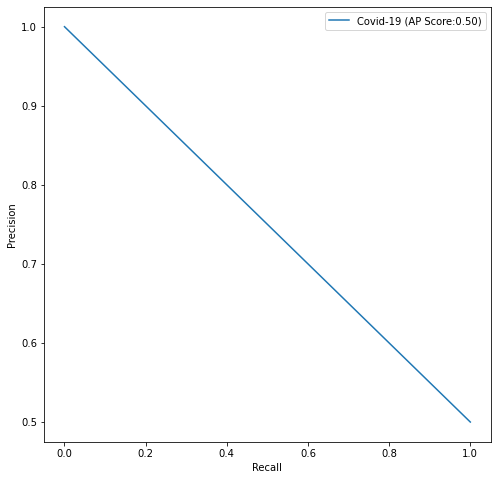

In [47]:
def pr_curve(y_true, y_pred):
    
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)
    ax.plot(recall, precision, label='%s (AP Score:%.2f)' % ('Covid-19', average_precision_score(y_true, y_pred)))
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
pr_curve(y_true, y_pred)

In [48]:
report = classification_report(y_true, y_pred)
print ('\nClassification Report:\n',report)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        15
         1.0       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



In [49]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        if(len(t)==0):            
            break
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

[0.0, 0.0, 0.0]
[0.5, 1.0, 0.67]


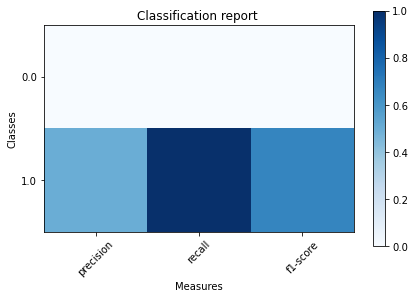

In [50]:
plot_classification_report(report)

In [51]:
def store_model_info(file_path, model_name, classifier, optimizer_name, lr, min_valid_loss, test_loss):
    with open(file_path, 'a') as f:

        classifier_info = '\n'.join(str(layer) for layer in classifier)

        row = [model_name, classifier_info, optimizer_name, lr, min_valid_loss, test_loss]
        # create the csv writer
        writer = csv.writer(f)

        # write a row to the csv file
        writer.writerow(row)

In [52]:
#min_valid_loss = min(losses[:, 1])

#store_model_info('model_info.csv', 'googlenet1', model.fc, optimizer.__class__.__name__, lr, min_valid_loss, test_loss)

# predict on new Images

In [53]:
def predict(img_path):
    with torch.no_grad():
        img=Image.open(img_path).convert('RGB')
        img= test_transform(img).unsqueeze(0)
        model.load_state_dict(torch.load('model0.pt'))

        model.eval()
        preds = torch.sigmoid(model.forward(img))
        return preds


# test on a sample image
predict('D:/Data/COVID-19-master/person88_virus_167.jpeg')

tensor([[0.2570]])

Covid ... Normal image Possibility = 25.70%


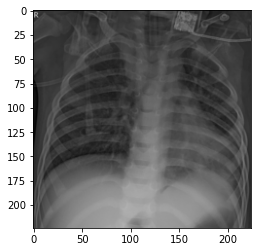

In [54]:
def predict_show(img_path):
    preds = predict(img_path)
    img=Image.open(img_path).convert('RGB')
    img= test_transform(img)
    img = img.numpy().transpose(1, 2, 0)*std+mean
    plt.imshow(img.clip(0, 1))
    print(f"{'Normal' if preds > 0.5 else 'Covid'} ... Normal image Possibility = {preds.item()*100:.2f}%")


# test on a sample image
predict_show('D:/Data/COVID-19-master/person88_virus_167.jpeg')  # Positive